# Demo I - Training ML Algorithms

In [ ]:
# install specific version of pandas and progress bar just in case
!pip install tqdm pandas==1.0.3

In [1]:
import pathlib
import sys

# define the top level directory
PROJECT_PATH = pathlib.Path("/media/disk/erc/papers/2019_ML_OCN/")
CODE_PATH = PROJECT_PATH.joinpath("ml4ocean")
sys.path.append(str(CODE_PATH))

# ml4ocean packages
from src.utils import get_paths
from src.data.world import get_full_data, world_features
from src.features.world import subset_independent_floats

PATHS = get_paths()

# standard pacakges
import tqdm
import time
import numpy as np
import pandas as pd
from scipy import stats

# ML packages
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

# ML preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# statistics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-paper'])

import warnings
warnings.simplefilter("ignore")

%load_ext autoreload
%autoreload 2

## Data

In [2]:
inputs_df = pd.read_csv(f"{PATHS.data_interim.joinpath('inputs.csv')}")
outputs_df = pd.read_csv(f"{PATHS.data_interim.joinpath('outputs.csv')}")

# create meta index
inputs_df = inputs_df.set_index(world_features.meta)
outputs_df = outputs_df.set_index(world_features.meta)

## Train-Test Split

In [3]:
train_size = 0.8
random_state = 42

xtrain, xtest, ytrain, ytest = train_test_split(
    inputs_df, 
    outputs_df, 
    train_size=train_size,
    random_state=random_state
)

print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)

(19763, 26) (4941, 26)
(19763, 19) (4941, 19)


## Standardize the Inputs / Outputs

In [4]:
x_scaler = StandardScaler().fit(xtrain)
y_scaler = StandardScaler(with_std=False).fit(ytrain)

# scale inputs
xtrain_scaled = pd.DataFrame(x_scaler.transform(xtrain), columns=xtrain.columns, index=xtrain.index)
xtest_scaled = pd.DataFrame(x_scaler.transform(xtest), columns=xtest.columns, index=xtest.index)

# scale outputs
ytrain_scaled = pd.DataFrame(y_scaler.transform(ytrain), columns=ytrain.columns, index=ytrain.index)
ytest_scaled = pd.DataFrame(y_scaler.transform(ytest), columns=ytest.columns, index=ytest.index)


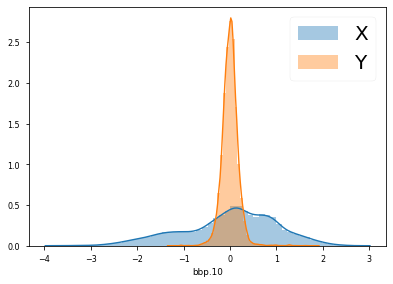

In [5]:
sns.distplot(xtrain_scaled.iloc[:, 14], label='X')
sns.distplot(ytrain_scaled.iloc[:, 10], label='Y')
plt.legend(fontsize=20)

## ML Algorithms

### Model - Random Forest Regressor

In [6]:
model = RandomForestRegressor(
    n_estimators=2_000,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    warm_start=True,
    criterion='mse'
)

In [7]:
t0 = time.time()
model.fit(xtrain_scaled, ytrain_scaled)
t1 = time.time() - t0
print(f"Time Taken: {t1} secs")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:  1.4min


Time Taken: 95.3053548336029 secs


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.6min finished


#### Viz I - Training Data

In [16]:
ypred_train = model.predict(xtrain_scaled)
ypred_train = pd.DataFrame(ytrain_scaled, columns=ytrain_scaled.columns, index=ytrain_scaled.index)

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.2s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.5s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.9s
[Parallel(n_jobs=28)]: Done 1194 tasks      | elapsed:    1.3s
[Parallel(n_jobs=28)]: Done 1744 tasks      | elapsed:    1.8s
[Parallel(n_jobs=28)]: Done 2000 out of 2000 | elapsed:    2.1s finished


In [ ]:
np.minimum(y)

In [17]:
from src.visualization.world import plot_residuals

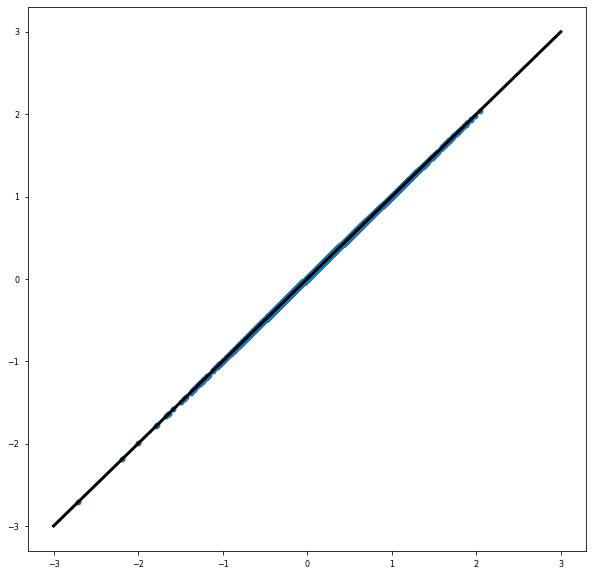

In [25]:
fig, ax = plot_residuals(ypred_train.values.ravel(), ytrain_scaled.values.ravel(), 'train')

#### Viz II - Testing Data

In [23]:
# Apply MLP to the test dataset
ypred_scaled = model.predict(xtest_scaled)

# Detransform the outputs:
ypred = pd.DataFrame(
    y_scaler.inverse_transform(ypred_scaled),
    columns=ytest_scaled.columns,
    index=ytest_scaled.index
)
ytest_c = pd.DataFrame(
    y_scaler.inverse_transform(ytest_scaled),
    columns=ytest_scaled.columns,
    index=ytest_scaled.index
)



# make vectors
ypred_vec = ypred.values.ravel()
ytest_vec = ytest_c.values.ravel()

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.2s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.4s
[Parallel(n_jobs=28)]: Done 1194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=28)]: Done 1744 tasks      | elapsed:    0.8s
[Parallel(n_jobs=28)]: Done 2000 out of 2000 | elapsed:    0.8s finished


**Statistics**

In [13]:
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

mapd = median_absolute_percentage_error(pow(10, ytest_vec), pow(10, ypred_vec))
mse = mean_squared_error(pow(10, ytest_vec), pow(10, ypred_vec))
rmse = np.sqrt(mse)
r2 = r2_score(ytest_vec, ypred_vec)

slope_0, *_ = stats.linregress(ytest_vec, ypred_vec)




print(f"MAPD: {mapd:.2f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"Slope: {slope_0:.4f}")

MAPD: 10.99%
MSE: 0.0000
RMSE: 0.0004
R2: 0.8701
Slope: 0.8572


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcaa83b2080>)

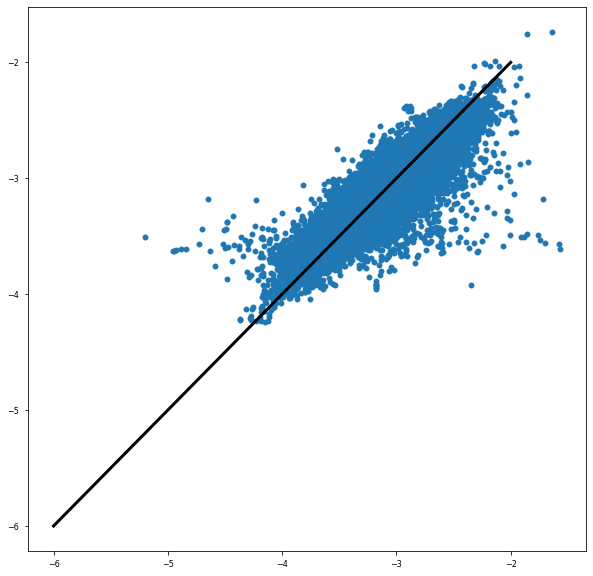

In [26]:
plot_residuals(ytest_vec, ypred_vec, 'test')

### Cross Validation

### Method I - From Scratch

In [84]:
def standardize_data(Xtrain, Xtest, ytrain, ytest):
    
    x_scaler = StandardScaler().fit(Xtrain)
    y_scaler = StandardScaler(with_std=False).fit(ytrain)

    # scale inputs
    Xtrain_scaled = x_scaler.transform(Xtrain)
    Xtest_scaled = x_scaler.transform(Xtest)

    # scale outputs
    ytrain_scaled = y_scaler.transform(ytrain)
    ytest_scaled = y_scaler.transform(ytest)
    scalers = {'x': x_scaler, 'y': y_scaler}
    return Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled, scalers


In [91]:
# define the model
model = RandomForestRegressor(
    n_estimators=2_000,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    warm_start=False,
    criterion='mse'
)

# define the split
n_splits = 10
kf = KFold(n_splits=n_splits)

predictions_test = list()
predictions_train = list()

for train_index, test_index in tqdm.tqdm(kf.split(inputs_df.values), total=n_splits):
    
    # segment data
    Xtr, Xte, ytr, yte, scalers = standardize_data(
        inputs_df.values[train_index, :],
        inputs_df.values[test_index, :],
        outputs_df.values[train_index, :],
        outputs_df.values[test_index, :],
    )

    # train model
    model.fit(Xtr, ytr)
    
    
    # predictions
    predictions_train.append((model.predict(Xtr), ytr, scalers))
    predictions_test.append((model.predict(Xte), yte, scalers))


100%|██████████| 10/10 [18:10<00:00, 109.07s/it]


In [92]:
[r2_score(iscale['y'].inverse_transform(x).ravel(), iscale['y'].inverse_transform(y).ravel()) for (y, x, iscale) in predictions_train]

[0.9831090704366079,
 0.9835754471993815,
 0.983328216844481,
 0.9833219144776779,
 0.983307743737022,
 0.9829904097669607,
 0.982817987510845,
 0.983174345701849,
 0.9830150417288622,
 0.9828010707842838]

In [93]:
[r2_score(iscale['y'].inverse_transform(x).ravel(), iscale['y'].inverse_transform(y).ravel()) for (y, x, iscale) in predictions_test]

[0.7186974424983624,
 0.7071992892898138,
 0.6647674379299724,
 0.8125536947385796,
 0.7271490083454055,
 0.6957871257819145,
 0.8164298170713613,
 0.6147107331177086,
 0.7808035958518491,
 0.7484396890420137]

#### Other Ways

* [Tutorial](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
* [sklearn](https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py)
* [visualize](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)